# No 1.  Find a, k, b, with Save load model

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.functional import F
from copy import copy
import seaborn as sns
sns.set_style("whitegrid")


In [3]:
n = 3000
x = torch.arange(n, dtype=torch.float32)
a, k, b, f = 0.5, .3, 0.1, 0.85


x[0:50]

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
        28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41.,
        42., 43., 44., 45., 46., 47., 48., 49.])

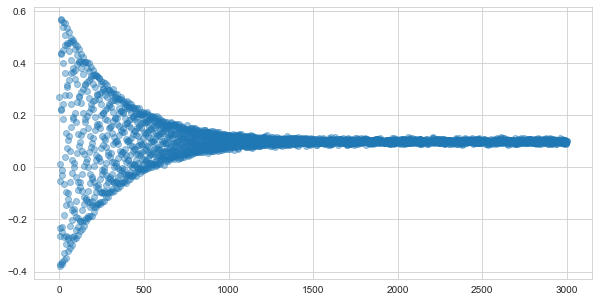

In [4]:
noise = torch.Tensor(np.random.normal(0, 0.005, size=n))

a, k, b, f = 0.5, .3, 0.1, 0.35

y = a * torch.exp(-k * x/100)*torch.sin(100*x+f) + b + noise

plt.figure(figsize=(10, 5))
plt.scatter(x, y, alpha=0.4)

In [14]:
class ExpoModel(nn.Module):
  def __init__(self):
    super().__init__()

    weights = torch.distributions.Uniform(0, 0.1).sample((4, ))
    self.weights = nn.Parameter(weights)
    
  # Forward method to define the computation in the model
  def forward(self, x: torch.Tensor) :
    a, k, b, f = self.weights
    return a * torch.exp(-k * x/100) * torch.sin(100*x+f) + b

In [20]:
torch.manual_seed(420)
model  = ExpoModel()
list(model.parameters())

# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)

In [22]:
model.state_dict()

OrderedDict([('weights', tensor([0.0805, 0.0199, 0.0976, 0.0103]))])

### SPLIT DATA

In [23]:
train_split = int(0.8 * len(x))
X_train, y_train = x[:train_split], y[:train_split]
X_test, y_test = x[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)
type(X_train), type(y_train), type(X_test), type(y_test)

(torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor)

In [26]:
# An epoch is one loop through the data... (this is a hyperparameter because we've set it ourselves)
epochs = 500

# Track different values
epoch_count = []
loss_values = []
test_loss_values = []

### Training
for epoch in range(epochs):
  model.train()
  
  y_pred = model(X_train)
  loss = loss_fn(y_pred, y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ### Testing
  model.eval()
  with torch.inference_mode():
    test_pred = model(X_test)
    test_loss = loss_fn(test_pred, y_test)

  # Print out what's happenin'
  if epoch % 50 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
    # Print out model state_dict()
    print(model.state_dict())

Epoch: 0 | Loss: 0.045900311321020126 | Test loss: 0.02127276174724102
OrderedDict([('weights', tensor([0.0751, 0.0300, 0.0984, 0.0106]))])
Epoch: 50 | Loss: 0.0358588732779026 | Test loss: 0.005643888842314482
OrderedDict([('weights', tensor([0.0746, 0.0871, 0.1000, 0.0149]))])
Epoch: 100 | Loss: 0.0328984335064888 | Test loss: 0.004712550900876522
OrderedDict([('weights', tensor([0.1016, 0.1141, 0.1001, 0.0196]))])
Epoch: 150 | Loss: 0.030203338712453842 | Test loss: 0.004343162290751934
OrderedDict([('weights', tensor([0.1307, 0.1356, 0.1001, 0.0252]))])
Epoch: 200 | Loss: 0.02784206159412861 | Test loss: 0.00415661558508873
OrderedDict([('weights', tensor([0.1591, 0.1536, 0.0999, 0.0321]))])
Epoch: 250 | Loss: 0.02574576437473297 | Test loss: 0.004061056300997734
OrderedDict([('weights', tensor([0.1864, 0.1690, 0.0999, 0.0399]))])
Epoch: 300 | Loss: 0.02390146814286709 | Test loss: 0.004009947180747986
OrderedDict([('weights', tensor([0.2124, 0.1821, 0.1000, 0.0488]))])
Epoch: 350 

In [27]:
np.array(torch.tensor(loss_values).numpy()), test_loss_values

(array([0.04590031, 0.03585887, 0.03289843, 0.03020334, 0.02784206,
        0.02574576, 0.02390147, 0.02222224, 0.02067027, 0.0192605 ],
       dtype=float32),
 [tensor(0.0213),
  tensor(0.0056),
  tensor(0.0047),
  tensor(0.0043),
  tensor(0.0042),
  tensor(0.0041),
  tensor(0.0040),
  tensor(0.0040),
  tensor(0.0040),
  tensor(0.0040)])